# `pymdptoolbox` demo

In [1]:
import warnings

from mdptoolbox import mdp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## The problem
* You have a 20-sided die, and you get to roll repeatedly until the sum of your rolls either gets as close as possible to 21 or you bust.
* Your score is the numerical value of the sum of your rolls; if you bust, you get zero.
* What is the optimal strategy?

![state diagram](d20_mdp.png)

## The solution

Let's look at what we have to deal with:
* State space is 23-dimensional (sum of rolls can be 0-21 inclusive, plus the terminal state)
* Action space is 2-dimensional (roll/stay)
* State transitions are stochastic; requires transition matrix $T(s^\prime;s,a)$
* $T$ is mildly sparse (some transitions like 9->5 or 0->21 are impossible)
* Rewards depend on both state and action taken from that state, but are not stochastic (only ever get positive reward when choosing "stay")

We're going to use the [*value iteration*](https://pymdptoolbox.readthedocs.io/en/latest/api/mdp.html#mdptoolbox.mdp.ValueIteration) algorithm. Looking at the documentation, we can see that it requires as input a transition matrx, a reward matrix, and a discount factor (we will use $\gamma = 1$).

Let's first specify the transition "matrix". It's going to be a 3-dimensional tensor of shape $(|\mathcal{A}|,|\mathcal{S}|,|\mathcal{S}|) = (2, 23, 23)$. Most entries are probably zero, so let's start with a zero matrix and fill in the blanks. I'm going reserve the very last state (the 23rd entry) for the terminal state.

In [2]:
def make_transition_matrix(n_sides=20, max_score=21):
    """Constructs the transition matrix for the MDP
    
    Arguments:
        n_sides: number of sides on the die being rolled
        max_score: the maximum score of the game before going bust
    Returns:
        np.ndarray: array of shape (A,S,S), where A=2, and S=max_score+2
            representing the transition matrix for the MDP
    """
    A = 2
    S = max_score + 2
    T = np.zeros(shape=(A, S, S))
    p = 1/n_sides

    # All the "roll" action transitions
    # First, the transition from state s to any non terminal state s' has probability
    # 1/n_sides unless s' <= s or s' > s + n_sides
    for s in range(0, S-1):
        for sprime in range(s+1, S-1):
            if sprime <= s + n_sides:
                T[0,s,sprime] = p
    # The rows of T[0] must all sum to one, so all the remaining probability goes to
    # the terminal state
    for s in range(0, S-1):
        T[0,s,S-1] = 1 - T[0,s].sum()
    # It is impossible to transition out of the terminal state; it is "absorbing"
    T[0,S-1,S-1] = 1

    # All the "stay" action transitions
    # This one is simple - all "stay" transitions dump you in the terminal state,
    # regardless of starting state
    T[1,:,S-1] = 1
    
    T[T<0] = 0 # There may be some very small negative probabilities due to rounding
               # errors - this fixes errythang
    
    return T

In [3]:
# Take a peek at a smaller version 
T = make_transition_matrix(n_sides=4, max_score=5)
print("roll transitions:")
print(T[0])
print("\nstay transitions:")
print(T[1])

roll transitions:
[[0.   0.25 0.25 0.25 0.25 0.   0.  ]
 [0.   0.   0.25 0.25 0.25 0.25 0.  ]
 [0.   0.   0.   0.25 0.25 0.25 0.25]
 [0.   0.   0.   0.   0.25 0.25 0.5 ]
 [0.   0.   0.   0.   0.   0.25 0.75]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]]

stay transitions:
[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]


Now let's build the reward matrix. This is going to be a tensor of shape $(|\mathcal{S}|,|\mathcal{A}|) = (23,2)$. This one is even simpler than the transition matrix because only "stay" actions generate nonzero rewards, which are equal to the index of the state itself.

In [4]:
def make_reward_matrix(max_score=21):
    """Create the reward matrix for the MDP.
    
    Arguments:
        max_score: the maximum score of the game before going bust
    Returns:
        np.ndarray: array of shape (S,A), where A=2, and S=max_score+2
            representing the reward matrix for the MDP
    """
    A = 2
    S = max_score + 2
    R = np.zeros(shape=(S, A))
    
    # Only need to create rewards for the "stay" action
    # Rewards are equal to the state index, except for the terminal state, which
    # always returns zero
    for s in range(0, S-1):
        R[s,1] = s
    
    return R

In [5]:
# Take a peek at a smaller version
R = make_reward_matrix(max_score=5)
print("roll rewards:")
print(R[:,0])
print("\nstay rewards:")
print(R[:,1])

roll rewards:
[0. 0. 0. 0. 0. 0. 0.]

stay rewards:
[0. 1. 2. 3. 4. 5. 0.]


## The algorithm

Alright, now that we have the transition and reward matrices, our MDP is completely defined, and we can use the `pymdptoolbox` to help us figure out the optimal policy/strategy. 

In [6]:
n_sides = 20
max_score = 21

T = make_transition_matrix(n_sides, max_score)
R = make_reward_matrix(max_score)

model = mdp.ValueIteration(
    transitions=T,
    reward=R,
    discount=1,
    epsilon=0.001,
    max_iter=1000,
)
model.setVerbose()
model.run()
print(f"Algorithm finished running in {model.time:.2e} seconds")

  Iteration		V-variation
    1		  21.0
    2		  10.5
    3		  2.535
    4		  0.3157500000000013
    5		  0.025199999999998113
    6		  0.0013518750000010016
    7		  4.931250000161924e-05
Iterating stopped, epsilon-optimal policy found.
Algorithm finished running in 9.73e-04 seconds


That ran pretty fast, didn't it? Unfortunately most realistic MDP problems have millions or billions of possible states (or more!), so this doesn't really scale very well. But it works for our small problem very well.

## The results

Now let's analyze the results. The `ValueIteration` object gives us easy access to the optimal value function and policy.

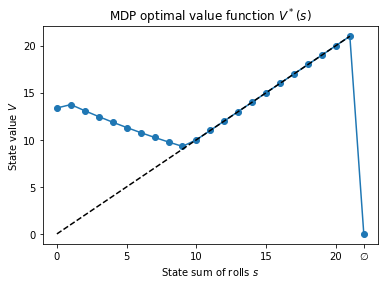

In [7]:
plt.plot(model.V, marker='o')
x = np.linspace(0, max_score, 10)
plt.plot(x, x, linestyle="--", color='black')
ticks = list(range(0, max_score+1, 5)) + [max_score+1]
labels = [str(x) for x in ticks[:-1]] + ["\u2205"]
plt.xticks(ticks, labels)
plt.xlim(-1, max_score+2)
plt.xlabel("State sum of rolls $s$")
plt.ylabel("State value $V$")
plt.title("MDP optimal value function $V^*(s)$")
plt.show()

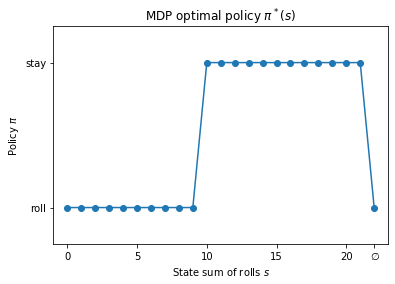

In [8]:
plt.plot(model.policy, marker='o')
ticks = list(range(0, max_score+1, 5)) + [max_score+1]
labels = [str(x) for x in ticks[:-1]] + ["\u2205"]
plt.xticks(ticks, labels)
plt.xlim(-1, max_score+2)
ticks = [0, 1]
labels = ["roll", "stay"]
plt.yticks(ticks, labels)
plt.ylim(-0.25, 1.25)
plt.xlabel("State sum of rolls $s$")
plt.ylabel("Policy $\pi$")
plt.title("MDP optimal policy $\pi^*(s)$")
plt.show()

Looks like the optimal policy is to keep rolling until the sum gets to 10. This is why $V(s) = s$ for $s>=10$ (black dashed line); because that's the score you end up with when following this policy. For $s<10$, it's actually a bit higher than $s$ because you get an opportunity to roll again to get a higher score, and the sum is low enough that your chances of busting are relatively low. We can see the slope is positive for $s \le 21 - 20 = 1$ because it's impossible to bust below that point, but the slope becomes negative between $1 \le s \le 10$ because you're more likely to bust the higher you get.

We can also calculate the state distribution $\rho_\pi(s_0 \rightarrow s,t)$, which tells us the probability to be in any one of the states $s$ after a time $t$ when starting from state $s_0$:

$$
\rho_\pi(s_0 \rightarrow s,t) = \sum_{s^\prime} T(s;s^\prime,\pi(s^\prime)) \rho_\pi(s_0 \rightarrow s^\prime, t-1) \\
\text{where }\rho_\pi(s_0 \rightarrow s, 0) = \delta_{s, s_0}
$$

In [9]:
def calculate_state_distribution(policy, T, t_max=10):
    S = len(policy)
    # Reduce transition matrix to T(s';s) since policy is fixed
    T_ = np.zeros(shape=(S, S))
    for s in range(S):
        for sprime in range(S):
            T_[s,sprime] = T[policy[s],s,sprime]
    T = T_
    
    # Initialize rho
    rho = np.zeros(shape=(S, S, t_max+1))
    for s in range(0, S):
        rho[s,s,0] = 1
        
    # Use the iterative update equation
    for t in range(1, t_max+1):
        rho[:,:,t] = np.einsum("ji,kj->ki", T, rho[:,:,t-1])
    
    return rho

In [10]:
rho = calculate_state_distribution(model.policy, T, 5)

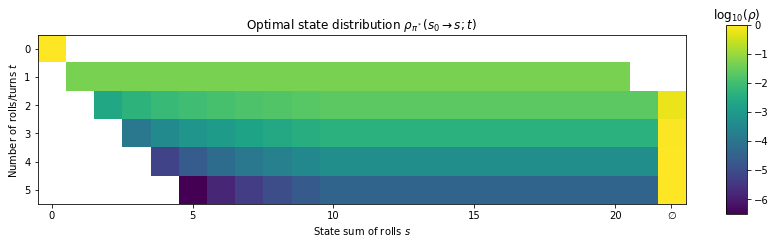

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Ignore the divide by zero error from taking log(0)
    plt.imshow(np.log10(rho[0].T), cmap='viridis')
cbar = plt.colorbar(shrink=0.35, aspect=9)
cbar.ax.set_title(r"$\log_{10}(\rho)$")
ticks = list(range(0, max_score+1, 5)) + [max_score+1]
labels = [str(x) for x in ticks[:-1]] + ["\u2205"]
plt.xticks(ticks, labels)
plt.xlabel("State sum of rolls $s$")
plt.ylabel("Number of rolls/turns $t$")
plt.title(r"Optimal state distribution $\rho_{\pi^*}(s_0\rightarrow s;t)$")
plt.subplots_adjust(right=2, top=2)
plt.show()